# **N07. Database managment automatization**

Create partitions of every retrieved database of possible objects. Then, extract the most interesting objects applying classification methods previously defined.

In [1]:
import pandas as pd
import pickle
import sqlite3
import os
import libraries.object_classification as oc
import numpy as np
import matplotlib.pyplot as plt
import json
#!pip install numpy==1.26.4


## 0. Re-save fits headers

Load fits files with 2.0 numpy and save them into numpy 1.26.4.

In [2]:
# Load metadata of used fits.
FITS_FOLDER = "resources/database/fits_db"
fits = os.listdir(FITS_FOLDER)
fits = [pd.read_pickle(os.path.join(FITS_FOLDER, file_fits)) for file_fits in fits]

# Merge all into one file.
all_fits = pd.concat(fits, axis = 0)
print(f"Number of fits analyzed: {len(all_fits)}")

ModuleNotFoundError: No module named 'numpy._core.numeric'

**Save into dict**

In [ ]:
def make_json_safe(val):
    
    # Already safe
    if val is None or isinstance(val, (str, int, float, bool)):
        return val
    # astropy/fits or any other object → str
    return str(val)

# Convert DataFrame to list of dicts
data_dict = all_fits.applymap(make_json_safe).to_dict(orient="records")

# Save to file
with open("fits_headers.json", "w", encoding="utf-8") as f:
    json.dump(data_dict, f, indent=2, ensure_ascii=False)


/tmp/ipykernel_33454/2304117717.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_dict = all_fits.applymap(make_json_safe).to_dict(orient="records")


**Save again as pickle**

In [ ]:
with open("fits_headers.json", "r", encoding="utf-8") as f:
    data_loaded = json.load(f)

df_back = pd.DataFrame(data_loaded)

df_back.to_pickle("resources/database/fits_db/fits_files12.pkl")


## 1. Partitionate database

Create partitions for every database computed.

In [2]:
# Define function for partitioning database.

def partition_database(database, input_folder, chunk_size, output_folder):
    """
    Create partition of a given database. 

    Parameters:
        database (.db): original database.
        input_folder (str): path-to-database.
        chunk_size (int): number of rows for each partition.
        output_folder (str): final destination for partitions.

    """
    table_name = "psfs"
    file_name = database[:-3]
    database = os.path.join(input_folder, database)

    conn = sqlite3.connect(database)
    # Extract total number of rows.
    total_rows = pd.read_sql(f"SELECT COUNT(*) FROM {table_name}", conn).iloc[0,0]

    for i in range(0, total_rows, chunk_size):
        # Select chunk of rows.
        query = f"SELECT * FROM {table_name} LIMIT {chunk_size} OFFSET {i}"
        chunk_df = pd.read_sql(query, conn)
        split_db_path = f"{file_name}_{i//chunk_size}.db"
        split_db_path = os.path.join(FOLDER_OUTPUT, split_db_path)

        # Save splitted database.
        with sqlite3.connect(split_db_path) as split_conn:
            chunk_df.to_sql(table_name, split_conn, index=False, if_exists="replace")
    
    conn.close()

**Automatize pipeline**

In [4]:
# Define global parameters.
FOLDER_DB = "resources/database/raw_db"
FOLDER_OUTPUT = "resources/database/sliced_db"
CHUNK_SIZE = 200000
# Retrive databases.
files = os.listdir(FOLDER_DB)

# Run files.

#for file in files:
    #partition_database(file, FOLDER_DB, CHUNK_SIZE, FOLDER_OUTPUT)

## 2. Extract objects.

### 2.1 Convert database into dataframe

In [5]:
def convert_to_objects(database, key = "object"):
    """
    Given a database, convert it back into a pandas with the respective filtered samples.

    Parameters:
        database(db): database with objects.
        key (str): type of PSF to extract.

    Output:
        possible_objects(dataframe): dataframe with desired PSFs.
    """

    # Stablish connection.
    conn = sqlite3.connect(database)
    # Retrieve files.
    possible_objects = pd.read_sql("SELECT * FROM psfs", conn)
    # Convert into pickle.
    possible_objects["REGION"] = possible_objects["REGION"].apply(pickle.loads)
    # Select target.
    possible_objects = possible_objects[possible_objects["PRE_LABEL"] == "object"]

    return possible_objects
    

### 2.2 Combine fits_file with binning factor.

Now, add the binning factor for each image based on the original information.

In [6]:
def select_binning(dataframe, original_dataframe, binning = 1):
    """
    Add binning factor into the main dataframe and filter based on a given factor.

    Parameters:
        dataframe(dataframe): objects retrieved.
        original_dataframe(dataframe): original information about each fits file.
        binning (int): binning factor for each image.

    Output:
        filtered_dataframe(dataframe): dataframe with filtered binning.
    """
    # Combine data.
    dataframe = pd.merge(dataframe, original_dataframe, on ="FILENAME", how = "inner")
    # Define binning factor.
    dataframe["binning"] = dataframe["width"].apply(
    lambda x: 1 if x == 2048.0 else (2 if x == 1024.0 else (4 if x == 512.0 else None))
        )   
    
    # Filter data.
    filtered_dataframe = dataframe[dataframe["binning"] == binning]

    return filtered_dataframe

In [7]:
# Load original data for FITS.
FITS_DATAFRAME = "resources/metis_all25022025151324.pkl"

# Prepare for feeding into pipeline.
headers_original = pd.DataFrame(pd.read_pickle(FITS_DATAFRAME))[["filename", "width", "url"]]
headers_original = headers_original.rename(columns={"filename": "FILENAME"})

**Automatize pipeline**

In [8]:
# Define paths.
OBJECTS_FOLDER = "resources/database/objects"
FOLDER_OUTPUT = "resources/database/sliced_db"
# Specify binning factor.
BINNING = 1
databases = os.listdir(FOLDER_OUTPUT)

# Run algorithm for every existent database.
for db_file in databases:

    # Convert into pandas.
    dataframe_raw = convert_to_objects(os.path.join(FOLDER_OUTPUT, db_file))
    
    # Extract objects with an specific binning factor.
    objects_raw = select_binning(dataframe_raw, headers_original, BINNING)

    # Apply classification.
    objects_refined = oc.obtain_interesting_objects(objects_raw)

    # Save files.
    objects_refined.to_pickle(os.path.join(OBJECTS_FOLDER, str(db_file[:-3])+".pkl"))

## 3. Concatenate results.

In [22]:
OBJECTS_FOLDER = "resources/database/objects"

object_files = os.listdir(OBJECTS_FOLDER)

objects_dataframes = [pd.read_pickle(os.path.join(OBJECTS_FOLDER, obj_file)) for obj_file in object_files]

objects_all = pd.concat(objects_dataframes, axis = 0)
objects_all.to_pickle("objects_all.pkl")

/tmp/ipykernel_15009/2740899339.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  objects_all = pd.concat(objects_dataframes, axis = 0)


**Norm images**

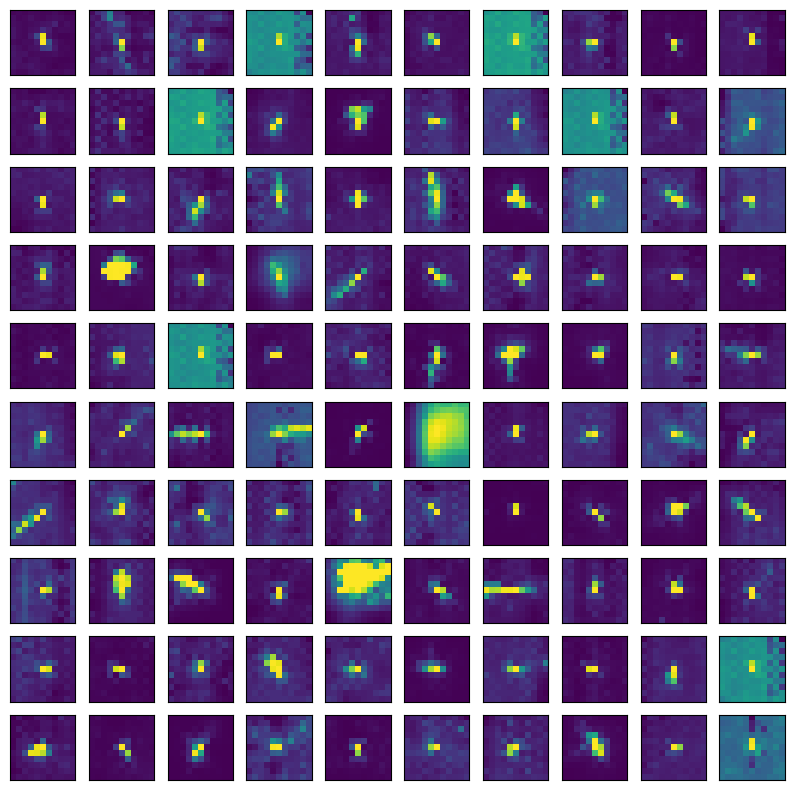

In [20]:
fig, axis = plt.subplots(10, 10, figsize = (10,10) )
axis = axis.flatten()

samples = objects_all.sample(100)

for i in range(100):
    img = samples["img_norm"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)

**Full images**

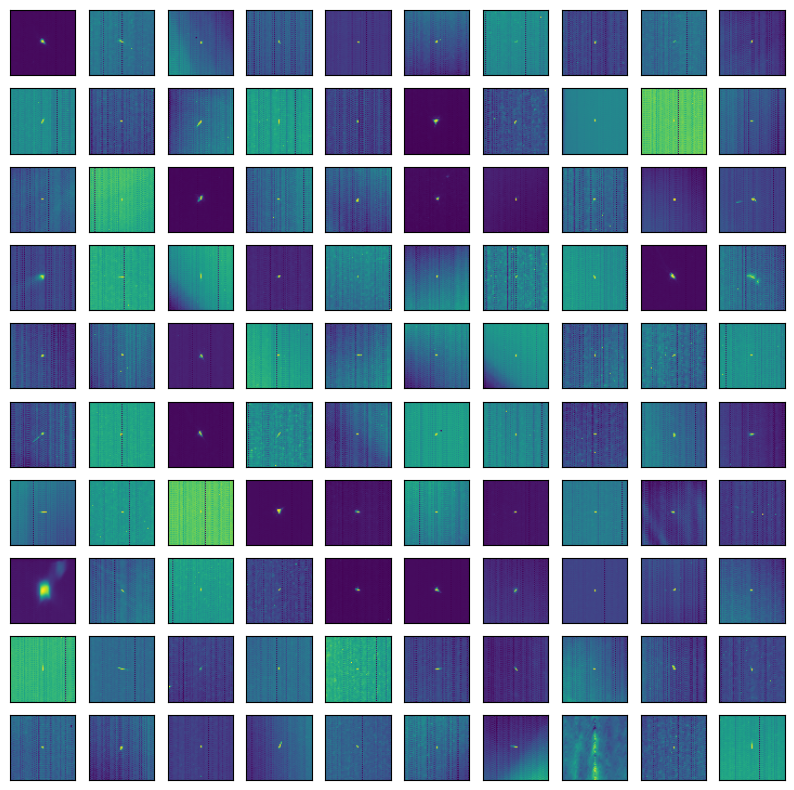

In [21]:
fig, axis = plt.subplots(10, 10, figsize = (10,10) )
axis = axis.flatten()

samples = objects_all.sample(100)

for i in range(100):
    img = samples["REGION"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)